<a href="https://colab.research.google.com/github/jtomfarrar/MIT12.805/blob/main/12805_pset6_2020_code_pieces_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop and test python code for 12.805 pset6
Tom Farrar  
November 12, 2020


Specifically, the goal is to develop functions analogous to the MATLAB ones I provided called ```centeredFFT.m```, ```band_avg.m```, ```confid.m```, and ```confidence_interval.m```.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from scipy import fft
from scipy import stats


Define some functions to use

In [2]:
def centeredFFT(x, dt):
    """
    Computes FFT, with zero frequency in the center, and returns 
    dimensional frequency vector.
    X, freq = centeredFFT(x, dt)
    
    Parameters
    ----------
    x : numeric
        1D array to be transformed by FFT
    dt : numeric
        Time increment (used to compute dimensional freuency array)

    Returns (tuple)
    -------
    X: FFT of input x, with zero frequency in the center
    freq: Dimensional frequency vector corresponding to X

    #function [X,freq]=centeredFFT(x,dt)
    #
    # Adapted from a matlab function written by Quan Quach of blinkdagger.com 
    # Tom Farrar, 2016, 2020 jfarrar@whoi.edu
    # converted from matlab 2020
    # This code was written for MIT 12.805 class
    """
    N = len(x)
    #Generate frequency index
    if N % 2 == 0:
        m= np.arange(-N/2,N/2,1) # N even; this includes start (-N/2) and does not include stop (+N/2)
        #m = mslice[-N / 2:N / 2 - 1]    # N even (Matlab syntax)
    else:
        m= np.arange(-(N-1)/2,(N-1)/2+1,1) # N odd
        #m = mslice[-(N - 1) / 2:(N - 1) / 2]    # N odd (Matlab syntax)
    
    freq = m / (N * dt) #the dimensional frequency scale
    X = fft.fft(x)
    X = fft.fftshift(X) #swaps the halves of the FFT vector so that the zero frequency is in the center\\
    #If you are going to compute an IFFT, first use X=ifftshift(X) to undo the shift}
    return (X, freq) # Return tuple; could instead do this as dictionary or list


In [3]:
def band_avg(yy, num):
    '''
    Compute block averages for band averaging.

    Parameters
    ----------
    yy : np.array
        1D array to be averaged.
    num : numeric
        number of adjacent data points to average.

    Returns
    -------
    Bin-averaged version of input data, subsampled by the factor num

    # Tom Farrar, 2016, 2020 jfarrar@whoi.edu
    # This code was written for MIT 12.805 class

    '''
    #MATLAB code:
    #yyi=0;
    #for n=1:num
    # yyi=yy(n:num:[end-(num-n)])+yyi;
    #end
    
    yyi = 0
    for n in np.arange(0, num): # 1:num
        yyi=yy[n:-(num-n):num]+yyi;
        
    yy_avg=yyi/num
    
    return yy_avg


Try to test the band-averaging code, which is actually just a bin average

In [4]:
N = 20000
dt = 1
t = np.arange(0,N*dt,dt)
f = 20/((N-1)*dt)
noise_val = 0.2 # desired noise std deviation
yb = 1 + noise_val*np.random.randn(N,)+0.75*np.sin(2*np.pi*f*t)


Text(0.5, 0, 'Time')

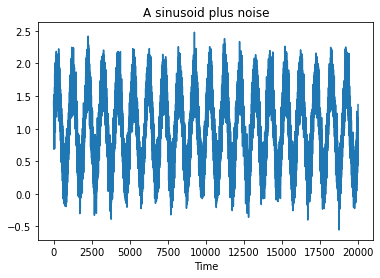

In [5]:
fig = plt.figure()
plt.plot(t, yb)
plt.title('A sinusoid plus noise')
# plt.ylabel('Z position (m)')
plt.xlabel('Time')



In [6]:
navg = 19
y_avg = band_avg(yb, navg)
t_avg = band_avg(t, navg)

In [7]:
np.shape(y_avg)

(999,)

Text(0.5, 1.0, 'Bin averaged version of the time series above')

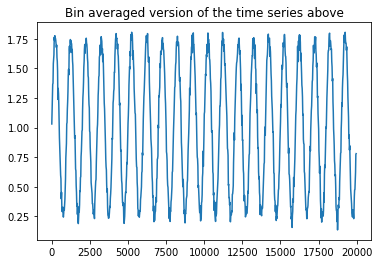

In [8]:
fig = plt.figure()
plt.plot(t_avg, y_avg)
plt.title('Bin averaged version of the time series above')
# plt.ylabel('Z position (m)')
# plt.xlabel('Time')

OK, great! The bin average code seems to work. (We could test this more rigorously, but OK so far.)

OK, now let's try doing a spectrum.  First, though, let's recall what we are wanting to do overall.  We want to make a function to estimate the band-averaged spectrum and plot it with a 95% confidence interval.  To do that, we will follow the steps from Section 4.7.1 of the class notes on spectral analysis:
  1. Compute the mean of the time series, $x(t)$ and subtract it from the time series.
  2. Optional: Taper the record using a taper window, $x_{taper}(t)=w(t)x(t)$.   A taper that gives equal weight to most of the record (like a Tukey window) may adequately suppress leakage, if tapering is needed at all. Normalize the taper window such that $ \frac{1}{N}\sum_{n=1}^{N} w_n^{2}=1$ so that the tapered time series has the same variance as the original one. (As an alternative to the normalizing the window, one could rescale the Fourier coefficients by the square root of the normalization constant, which is equivalent. Some prefer to compute the variance prior to windowing and rescale the spectrum to have that variance, which is also also fine but does not give identical results).
  3. Compute the FFT of the entire tapered record.
  4. Generate a frequency vector, $f_m=m/(N \Delta t)$ with m ranging from $-N/2$ to $N/2-1$ (for even $N$).
  5. Compute the raw, one-sided spectral density and discard frequencies $\leq0$.
  6. Band average the raw spectrum over $n_d$ frequency bands-- this could be done by an algorithm like equation \ref{band_avg_spectrum} or by computing a running average and subsampling.  Generate the new frequency vector, either by subsampling the Fourier frequencies at the interval of $n_d/T$ or by band averaging the frequency vector.
  7. Estimate a confidence interval (typically a 95\% confidence interval).  If no taper window was used, $2\times n_d$ is a good estimate of the number of degrees of freedom.  Tapering reduces the number of degrees of freedom because it reduces the linear independence of adjacent frequency bands; if the taper window is modest (uniform weighting over most of the time series), this reduction can be neglected.

Let's try following those steps and then put it together as a function.

             

1. Compute the mean of the time series, $x(t)$ and subtract it from the time series.

In [9]:
yy = yb # just renaming yb to mimic matlab code i have already written
N = len(yy)
T = N * dt
yy = yy - np.mean(yy)

2. Optional: Taper the record using a taper window, $x_{taper}(t)=w(t)x(t)$.
--> Let's skip that for now!

3. Compute the FFT of the entire tapered record.

In [10]:
(Y,freq_i) = centeredFFT(yy,dt)

  4. Generate a frequency vector, $f_m=m/(N \Delta t)$ with m ranging from $-N/2$ to $N/2-1$ (for even $N$).
  --> This was done by centeredFFT
  
  5. Compute the raw, one-sided spectral density and discard frequencies $\leq0$.
  --> Nomalization factor should be $2T/N^2$


In [11]:
ff = np.where(freq_i>0)
Y = Y[ff]
freq_i = freq_i[ff]
YY_raw = 2*T/N**2*Y*np.conj(Y)

  6. Band average the raw spectrum over $n_d$ frequency bands-- this could be done by an algorithm like equation \ref{band_avg_spectrum} or by computing a running average and subsampling.  Generate the new frequency vector, either by subsampling the Fourier frequencies at the interval of $n_d/T$ or by band averaging the frequency vector.  
--> We will use our band-averaging function on both the spectrum and the frequency vector.

In [12]:
M = 11
YY_avg = band_avg(YY_raw,M)
freq = band_avg(freq_i,M)

Text(0.5, 1.0, 'Band-averaged spectral estimate')

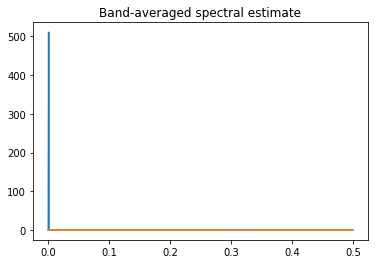

In [13]:
fig = plt.figure()
plt.plot(freq, np.real(YY_avg))
plt.plot(freq, np.imag(YY_avg))
plt.title('Band-averaged spectral estimate')

We were expecting the imaginary part to be zero.  It appears to be nonzero.  This may be a numerical artifact, but let's check this out.

Text(0.5, 1.0, 'Imaginary part of spectral estimate')

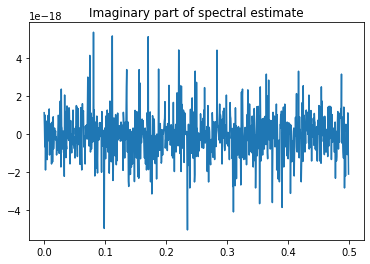

In [14]:
fig = plt.figure()
plt.plot(freq, np.imag(YY_avg))
plt.title('Imaginary part of spectral estimate')

OK, just as I suspected, the imaginary part is a numerical artifact, close to floating point precision.  The best way to handle this in the function we will build would probably be to check if the inputs are real, and, if they are, then just throw away the imaginary part of our spectral estimate.  (If the input time series is complex, we should expect some imaginary part in the spectrum.)

Text(0.5, 1.0, 'Band-averaged spectral estimate')

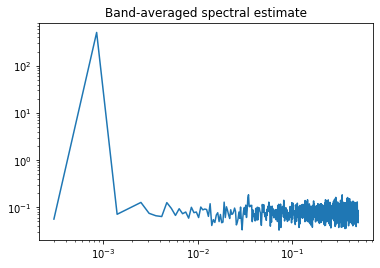

In [15]:
fig = plt.figure()
plt.loglog(freq, np.real(YY_avg))
plt.title('Band-averaged spectral estimate')

OK, I need axis labels (and units), but this isn't too terrible.

# Try working out confidence limits
In MATLAB, ```chi2inv(alpha/2,nu)``` returns $\chi^2_{\nu;\alpha/2}$. To compute confidence intervals, you simply need to compute the multiplicative factors $\nu/\chi^2_{\nu;\alpha/2}$ and $\nu/\chi^2_{\nu;1-\alpha/2}$.  Check values (e.g., Jenkins and Watts, 1968, p. 81) are $\nu/\chi^2_{19;0.025}=0.58$ and $\nu/\chi^2_{19;0.975}=2.11$ (I get 0.5783 and 2.1333 in MATLAB).

It seems that the analogous function in python's scipy.stats module is the "Inverse survival function" (stats.chi2.isf), which is defined as $\frac{1}{1-\textrm{cdf}}$, where $\textrm{cdf}$ is the cumulative distribution function of the chi-square distribution:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2


In [16]:
nu = 19
chi = stats.chi2.isf(0.025, nu)
nu / chi

0.5783456398680075

In [17]:
chi = stats.chi2.isf(1-0.025, nu)
nu / chi

2.1332695042359724

Great! We are ready to write the function that is analgous to confid.m!

In [18]:
def confid(alpha,nu):
    """
    Computes the upper and lower 100(1-alpha)% confidence limits for 
    a chi-square variate (e.g., alpha=0.05 gives a 95% confidence interval).
    Check values (e.g., Jenkins and Watts, 1968, p. 81) are $\nu/\chi^2_{19;0.025}=0.58$
    and $\nu/\chi^2_{19;0.975}=2.11$ (I get 0.5783 and 2.1333 in MATLAB).
    
   
    Parameters
    ----------
    alpha : numeric
        Number of degrees of freedom
    nu : numeric
        Number of degrees of freedom

    Returns (tuple)
    -------
    lower: lower bound of confidence interval
    upper: upper bound of confidence interval

    # Tom Farrar, 2020, jfarrar@whoi.edu
    # converted from matlab 2020
    # This code was written for MIT 12.805 class
    """
    
    # requires:
    # from scipy import stats
    
    upperv=stats.chi2.isf(1-alpha/2,nu)
    lowerv=stats.chi2.isf(alpha/2,nu)
    lower=nu / lowerv
    upper=nu / upperv
    
    return (lower, upper) # Return tuple; could instead do this as dictionary or list
    



Check again:

In [19]:
nu = 19
alpha = 0.05
lower, upper = confid(alpha, nu)

In [20]:
lower

0.5783456398680075

In [21]:
upper

2.1332695042359724

OK, that worked fine.  Now let's write a function that will place a nice error bar (confidence interval) on a log-log spectral plot.

Here's what my matlab code for that looked like:
```
function confidence_interval(alpha,nu,spot,yspot,wid,cstr);
% confidence_interval(alpha,nu,xspot,yspot,width,cstr);
%
%  Plot (1-alpha)*100% spectral confidence interval on a log-log scale
%
% Inputs:
%	alpha, 100*alpha is the percentage point of the chi-square distribution
%		For example, use alpha=0.05 for a 95% confidence interval
%	nu, number of degrees of freedom
%	xspot, horizontal coordinate for confidence interval (e.g., xspot=freq(3);)
%	yspot, vertical coordinate for confidence interval
%	width, width for top and bottom horizontal bars
%	cstr, color for confidence interval 
%		(for example, cstr='r'; or cstr=get(h1,'color');)
%
%
%
% This code was written for MIT 12.805 class
%
% Tom Farrar, 2016, jfarrar@whoi.edu

[low,up]=confid(alpha,nu);

lowzz=yspot*low;
upzz=yspot*up;
%plot confidence interval
loglog(spot,yspot,'o','color',cstr);
h3=loglog([spot spot], [lowzz,upzz],'color',cstr);
loglog([spot+wid spot-wid], [upzz,upzz],'color',cstr);
loglog([spot+wid spot-wid], [lowzz,lowzz],'color',cstr);
hh=text(1.1*spot,yspot,[num2str(100*(1-alpha)) '%']);
set(hh,'horizontalalignment','left')
```



In [ ]:
N = 20000
dt = 1
t = np.arange(0,N*dt,dt)
f = 20/((N-1)*dt)
noise_val = 0.2 # desired noise std deviation
yy = 1 + noise_val*np.random.randn(N,)+0.75*np.sin(2*np.pi*f*t)

N = len(yy)
T = N * dt
# Compute the mean of the time series and subtract it
yy = yy - np.mean(yy)

# Compute FFT and frequency scale, with lowest frequency in the center
(Y,freq_i) = centeredFFT(yy,dt)
# Discard negative frequencies 
ff = np.where(freq_i>0)
Y = Y[ff]
freq_i = freq_i[ff]
# Apply normalization for 1-sided spectral density
YY_raw = 2*T/N**2*Y*np.conj(Y)

#Carry out band averaging
M = 11
YY_avg = band_avg(YY_raw,M)
freq = band_avg(freq_i,M)